In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import datetime, os
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

2024-07-01 04:58:25.981110: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-01 04:58:25.981214: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-01 04:58:26.117579: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
#loading dataframes
train_df = pd.read_csv('/kaggle/input/rsna-bone-age/boneage-training-dataset.csv')
test_df = pd.read_csv('/kaggle/input/rsna-bone-age/boneage-test-dataset.csv')

#appending file extension to id column for both training and testing dataframes
train_df['id'] = train_df['id'].apply(lambda x: str(x)+'.png')
test_df['Case ID'] = test_df['Case ID'].apply(lambda x: str(x)+'.png') 

train_df.head()

,id,boneage,male
0,1377.png,180,False
1,1378.png,12,False
2,1379.png,94,False
3,1380.png,120,True
4,1381.png,82,False


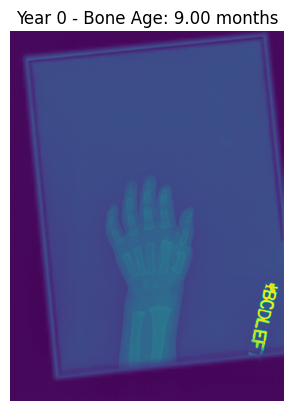

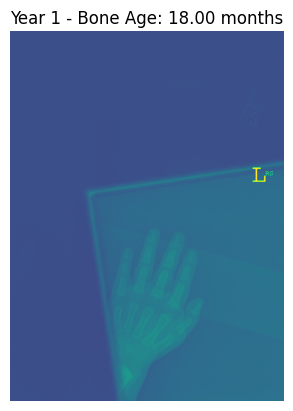

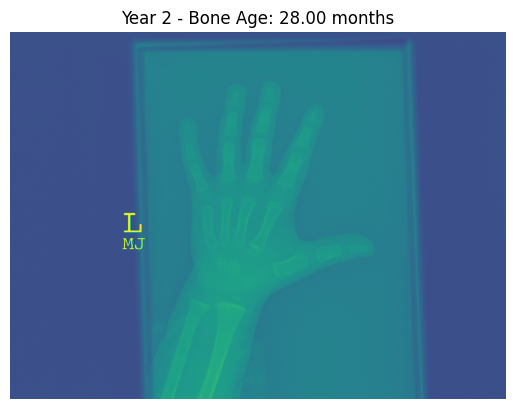

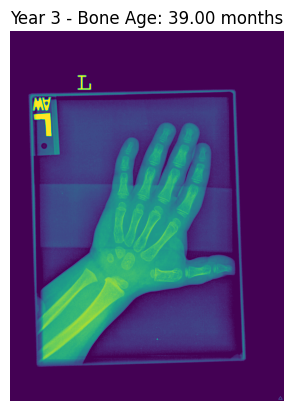

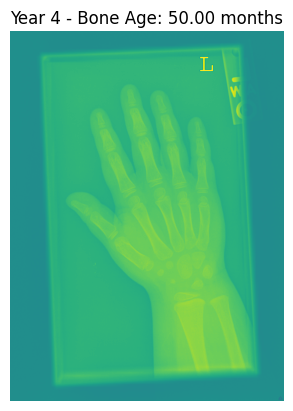

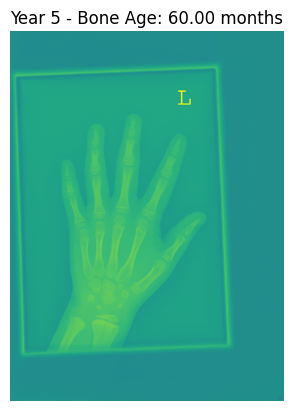

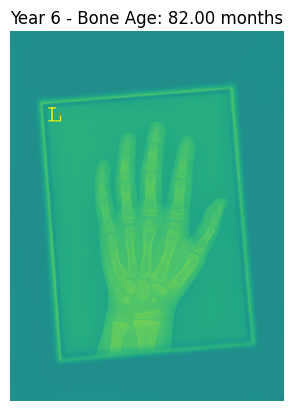

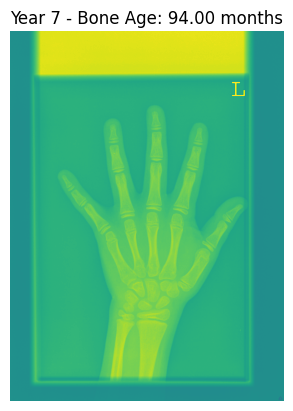

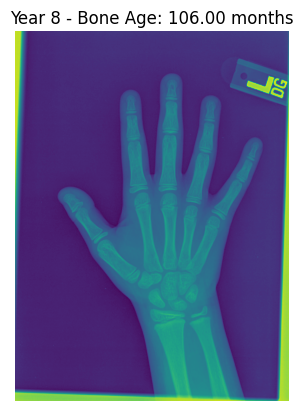

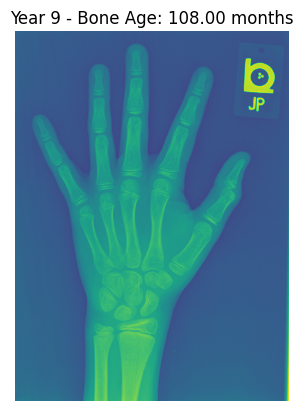

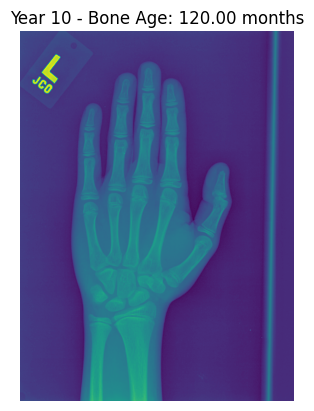

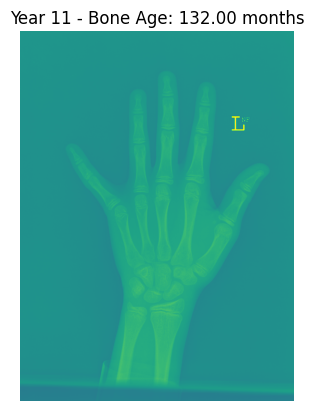

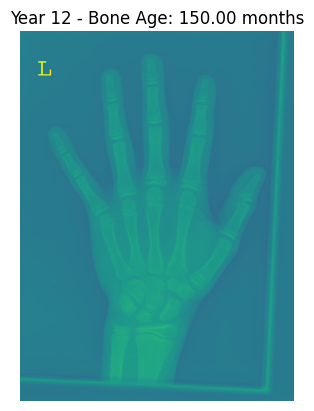

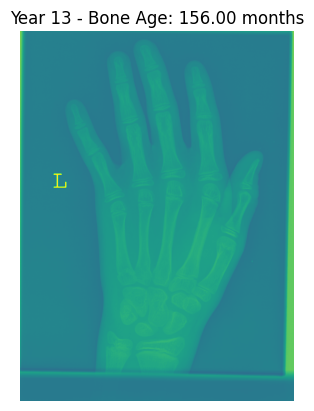

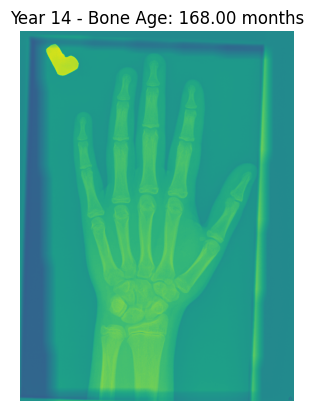

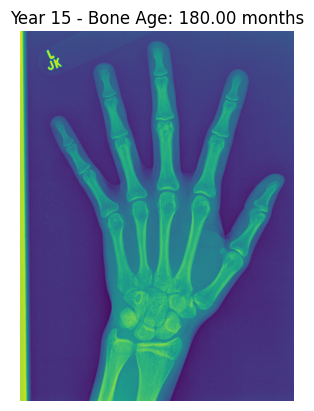

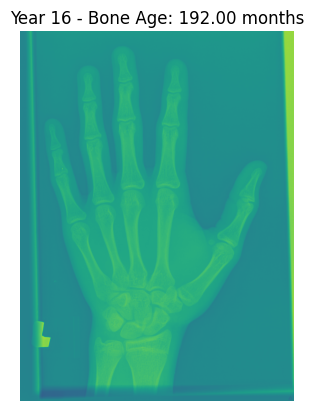

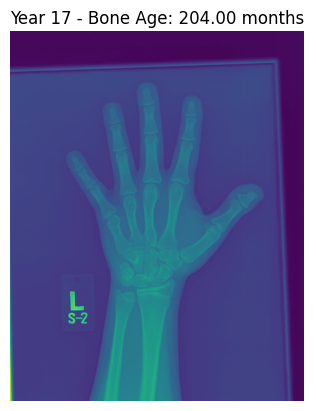

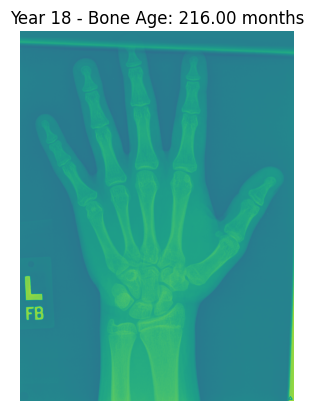

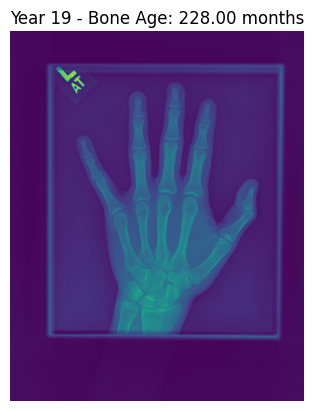

In [10]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you have already loaded the train_df dataframe
# and it contains columns: 'id', 'boneage', and 'male'

# Define the path to the image directory
image_directory = '/kaggle/input/rsna-bone-age/boneage-training-dataset/boneage-training-dataset/'

# Group images by year (based on bone age)
grouped_by_year = train_df.groupby(train_df['boneage'] // 12)

# Iterate through each group (year)
for year, group in grouped_by_year:
    # Choose the image closest to the median bone age for this year
    median_bone_age = group['boneage'].median()
    closest_image = group.loc[(group['boneage'] - median_bone_age).abs().idxmin()]

    # Load the image
    image_path = os.path.join(image_directory, closest_image['id'])
    image = plt.imread(image_path)

    # Display the image
    plt.imshow(image)
    plt.title(f"Year {year} - Bone Age: {median_bone_age:.2f} months")
    plt.axis('off')  # Hide axes
    plt.show()


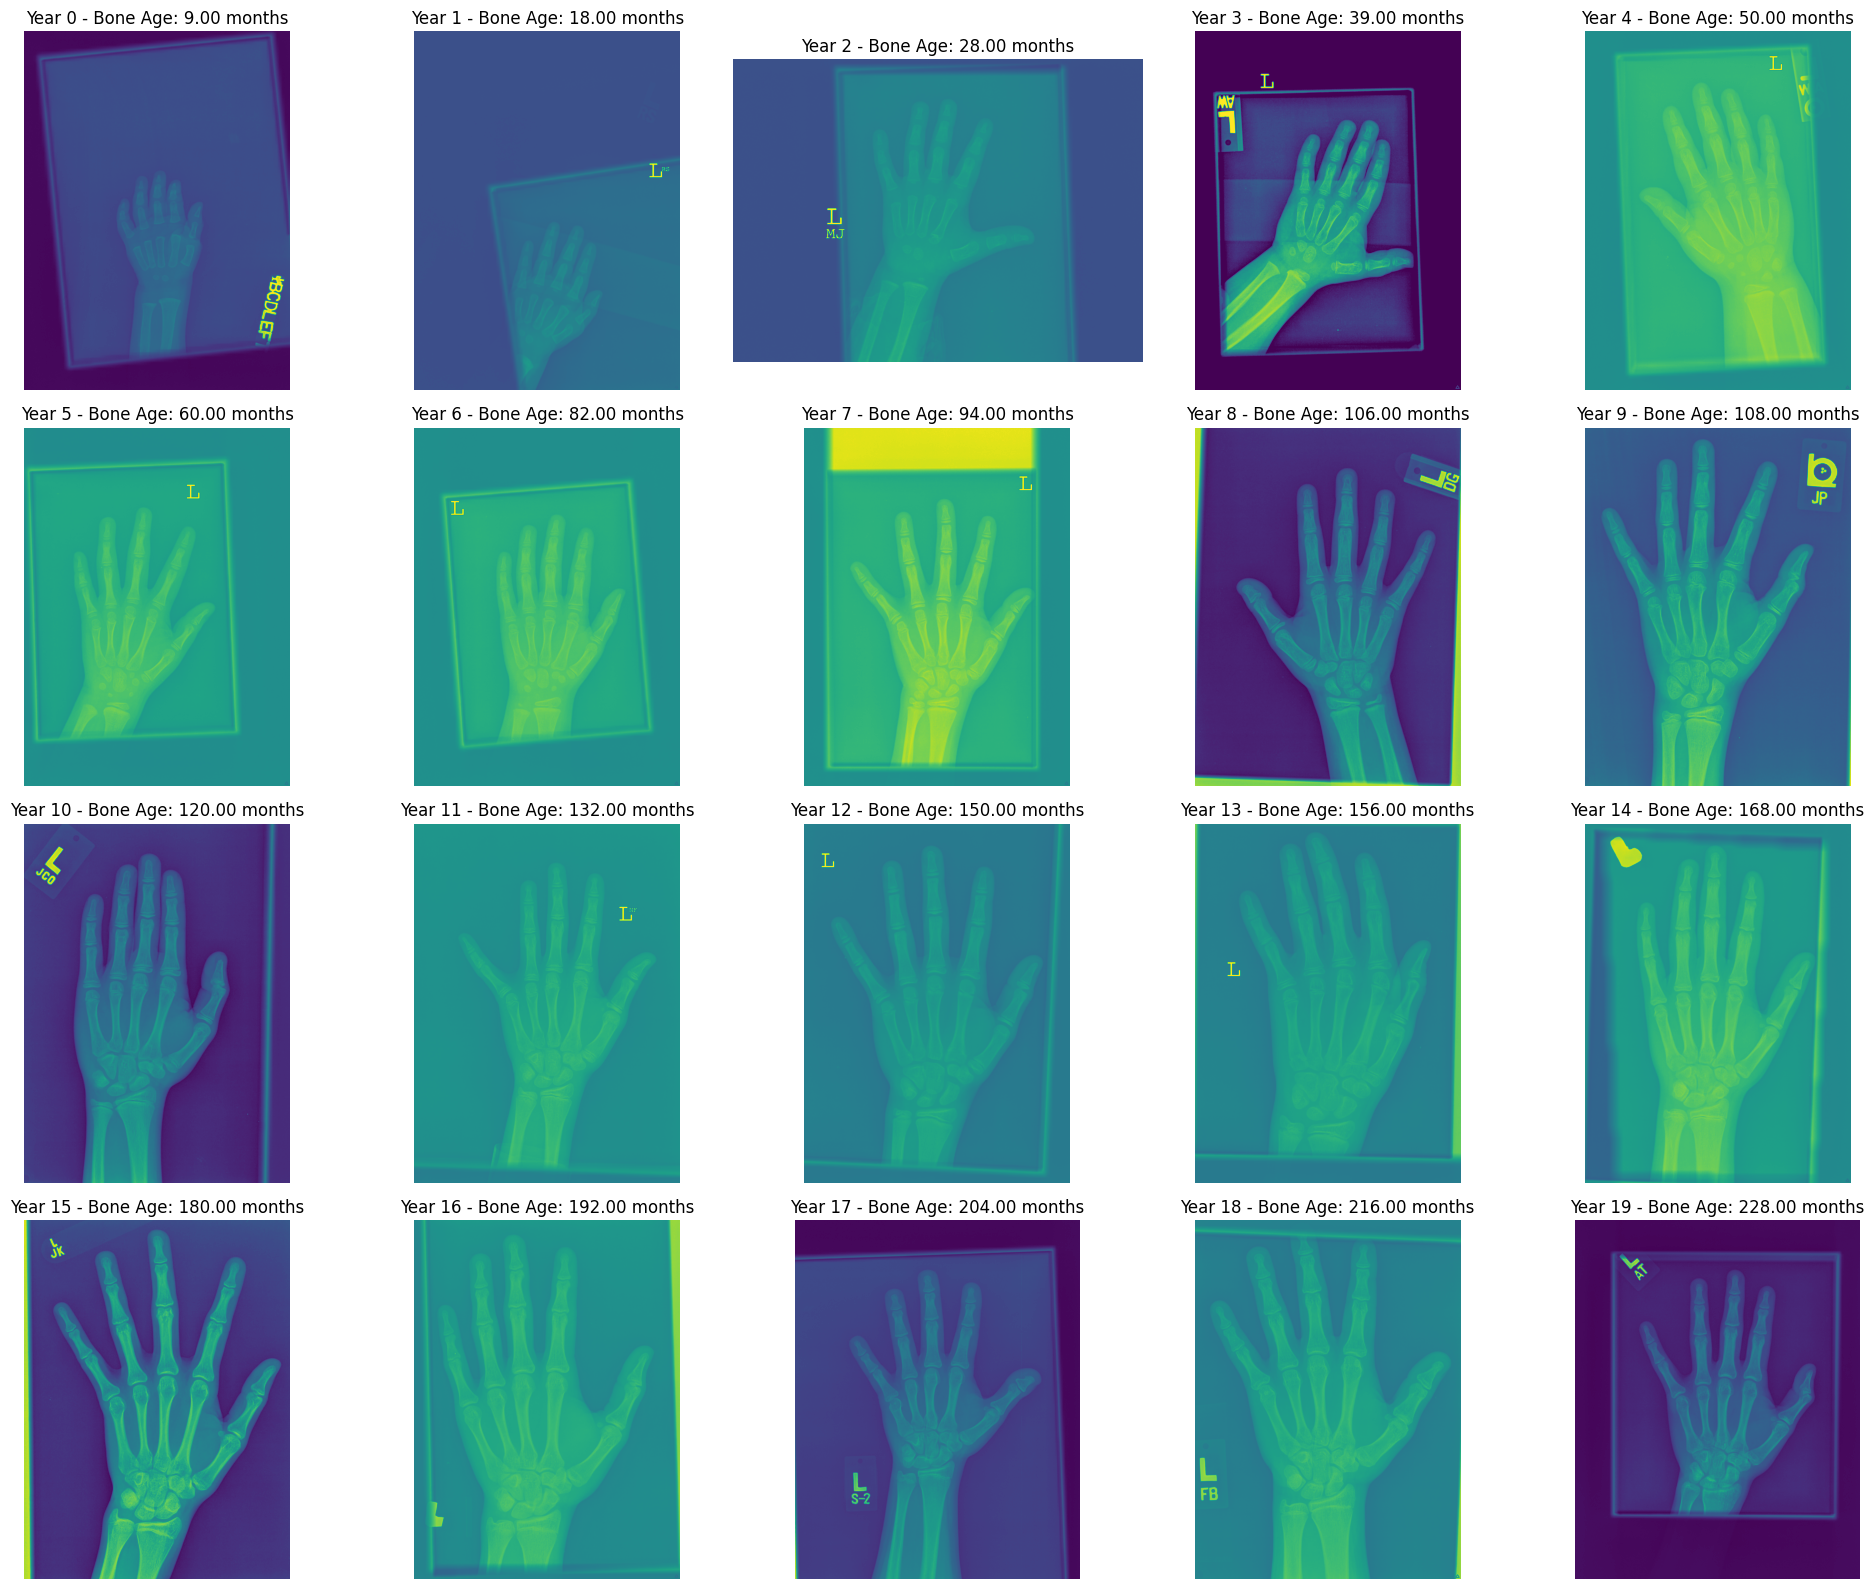

<Figure size 640x480 with 0 Axes>

In [15]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you have already loaded the train_df dataframe
# and it contains columns: 'id', 'boneage', and 'male'

# Define the path to the image directory
image_directory = '/kaggle/input/rsna-bone-age/boneage-training-dataset/boneage-training-dataset/'

# Group images by year (based on bone age)
grouped_by_year = train_df.groupby(train_df['boneage'] // 12)

# Initialize a 4x5 grid for displaying images
fig, axs = plt.subplots(4, 5, figsize=(20, 16))

# Iterate through each group (year)
for i, (year, group) in enumerate(grouped_by_year):
    # Choose the image closest to the median bone age for this year
    median_bone_age = group['boneage'].median()
    closest_image = group.loc[(group['boneage'] - median_bone_age).abs().idxmin()]

    # Load the image
    image_path = os.path.join(image_directory, closest_image['id'])
    image = plt.imread(image_path)

    # Display the image in the corresponding grid cell
    axs[i // 5, i % 5].imshow(image)
    axs[i // 5, i % 5].set_title(f"Year {year} - Bone Age: {median_bone_age:.2f} months")
    axs[i // 5, i % 5].axis('off')

plt.tight_layout()
plt.show()
plt.savefig('final_image.png')

In [6]:
import cv2
import os
from tqdm import tqdm  # Import tqdm for progress bar

def apply_clahe_and_threshold(input_path, output_path, clip_limit=5, threshold_value=155):
    with tf.device('/cpu:0'):

    # Create output directory if it doesn't exist
        os.makedirs(output_path, exist_ok=True)

        # List all image files in the input directory
        image_files = [f for f in os.listdir(input_path) if f.lower().endswith('.png')]

        for image_filename in tqdm(image_files, desc="Processing images"):  # tqdm for progress bar
            # Read image from file
            image = cv2.imread(os.path.join(input_path, image_filename))
            image = cv2.resize(image, (500, 600))

            # Convert to grayscale
            image_bw = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

            # Apply CLAHE
            clahe = cv2.createCLAHE(clipLimit=clip_limit)
            final_img = clahe.apply(image_bw)

            # Ordinary thresholding
            _, ordinary_img = cv2.threshold(image_bw, threshold_value, 255, cv2.THRESH_BINARY)
# Save transformed images
            cv2.imwrite(os.path.join(output_path, f"{image_filename}"), final_img)
    #         cv2.imwrite(os.path.join(output_path, f"threshold_{image_filename}"), ordinary_img)

# Define paths
input_dataset_path = '/kaggle/input/rsna-bone-age/boneage-training-dataset/boneage-training-dataset'
output_dataset_path = '/kaggle/working/boneage-training-dataset'  
clip_limit = 20
threshold_value = 155
with tf.device('/cpu:0'):
    apply_clahe_and_threshold(input_dataset_path, output_dataset_path, clip_limit, threshold_value)

Processing images: 100%|██████████| 12611/12611 [07:47<00:00, 26.95it/s]


In [7]:
input_dataset_path = '/kaggle/input/rsna-bone-age/boneage-test-dataset/boneage-test-dataset'
output_dataset_path = '/kaggle/working/boneage-test-dataset'  
clip_limit = 20
threshold_value = 155
with tf.device('/cpu:0'):
    apply_clahe_and_threshold(input_dataset_path, output_dataset_path, clip_limit, threshold_value)

Processing images: 100%|██████████| 200/200 [00:08<00:00, 23.49it/s]


In [8]:
#oldest child in the dataset
print('MAX age: ' + str(train_df['boneage'].max()) + ' months')

#youngest child in the dataset
print('MIN age: ' + str(train_df['boneage'].min()) + ' months')

#mean age is
mean_bone_age = train_df['boneage'].mean()
print('mean: ' + str(mean_bone_age))

#median bone age
print('median: ' +str(train_df['boneage'].median()))

#standard deviation of boneage
std_bone_age = train_df['boneage'].std()

#models perform better when features are normalised to have zero mean and unity standard deviation
#using z score for the training
train_df['bone_age_z'] = (train_df['boneage'] - mean_bone_age)/(std_bone_age)

print(train_df.head())

MAX age: 228 months
MIN age: 1 months
mean: 127.3207517246848
median: 132.0
         id  boneage   male  bone_age_z
0  1377.png      180  False    1.279181
1  1378.png       12  False   -2.800269
2  1379.png       94  False   -0.809109
3  1380.png      120   True   -0.177766
4  1381.png       82  False   -1.100498


In [9]:
#splitting train dataframe into traininng and validation dataframes
train_df['boneage_category'] = pd.cut(train_df['boneage'], 10)
df_train, df_valid = train_test_split(train_df, test_size = 0.2, random_state = 0)

In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from  keras.applications.xception import preprocess_input 

#reducing down the size of the image 
img_size = 299
data_augmenation = dict(rotation_range=0.2, zoom_range=0.1, horizontal_flip=True,
                                width_shift_range=0.05,
                                height_shift_range=0.05,
                                shear_range=0.05, fill_mode='nearest')
train_data_generator = ImageDataGenerator(preprocessing_function = preprocess_input,  **data_augmenation)
val_data_generator = ImageDataGenerator(preprocessing_function = preprocess_input)

#train data generator
train_generator = train_data_generator.flow_from_dataframe(
    dataframe = df_train,
    directory = '/kaggle/working/boneage-training-dataset',
    x_col= 'id',
    y_col= 'bone_age_z',
    batch_size = 32,
    seed = 42,
    shuffle = True,
    class_mode= 'other',
    flip_vertical = True,
    color_mode = 'rgb',
    target_size = (img_size, img_size))
val_generator = val_data_generator.flow_from_dataframe(
    dataframe = df_valid,
    directory = '/kaggle/working/boneage-training-dataset',
    x_col = 'id',
    y_col = 'bone_age_z',
    batch_size = 32,
    seed = 42,
    shuffle = True,
    class_mode = 'other',
    flip_vertical = True,
    color_mode = 'rgb',
    target_size = (img_size, img_size))

#test data generator
test_data_generator = ImageDataGenerator(preprocessing_function = preprocess_input)

test_generator = test_data_generator.flow_from_directory(
    directory = '/kaggle/working/boneage-test-dataset',
    shuffle = True,
    class_mode = None,
    color_mode = 'rgb',
    target_size = (img_size,img_size))

Found 10088 validated image filenames.
Found 2523 validated image filenames.
Found 0 images belonging to 0 classes.


In [15]:
test_X, test_Y = next(val_data_generator.flow_from_dataframe( 
                            df_valid, 
                            directory = '/kaggle/input/rsna-bone-age/boneage-training-dataset/boneage-training-dataset',
                            x_col = 'id',
                            y_col = 'bone_age_z', 
                            target_size = (img_size, img_size),
                            batch_size = 2523,
                            class_mode = 'other'
                            )) 

Found 2523 validated image filenames.


In [ ]:
def plot_it(history):
    '''function to plot training and validation error'''
    fig, ax = plt.subplots( figsize=(20,10))
    ax.plot(history.history['mae_in_months'])
    ax.plot(history.history['val_mae_in_months'])
    plt.title('Model Error')
    plt.ylabel('error')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper right')
    ax.grid(color='black')
    plt.show()

In [13]:
from keras.metrics import mean_absolute_error

def mae_in_months(x_p, y_p):
    return mean_absolute_error((std_bone_age*x_p + mean_bone_age), (std_bone_age*y_p + mean_bone_age))

In [9]:
from tensorflow.keras.layers import GlobalMaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import Sequential
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50

model_1 = tf.keras.applications.DenseNet201(input_shape = (img_size, img_size, 3),
                                           include_top = False,
                                           weights = 'imagenet')
model_1.trainable = True
model_2 = Sequential()
model_2.add(model_1)
model_2.add(GlobalMaxPooling2D())
model_2.add(Flatten())
model_2.add(Dense(64, activation = 'relu'))
# model_2.add(Dropout(0.5))
model_2.add(Dense(32, activation = 'relu'))
model_2.add(Dense(1, activation = 'linear'))

Sgd = tf.keras.optimizers.SGD(
    learning_rate=0.001, momentum=0.0, nesterov=False)
NaDam = tf.keras.optimizers.Nadam(
    learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
AdaMax = tf.keras.optimizers.Adamax(
    learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
#compile model
model_2.compile(loss ='mse', optimizer= AdaMax, metrics = [mae_in_months] )
model_2.summary()

74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet201 (Functional)        │ ?                      │    18,321,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d            │ ?                      │   0 (unbuilt) │
│ (GlobalMaxPooling2D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,321,984 (69.89 MB)

 Trainable params: 18,092,928 (69.02 MB)

 Non-trainable params: 229,056 (894.75 KB)

In [10]:
%load_ext tensorboard
logs_dir = '.\logs'
%tensorboard --logdir {logs_dir}

In [11]:
#early stopping
early_stopping = EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience= 12,
                              verbose=0, mode='auto')

#model checkpoint
mc = ModelCheckpoint('resnet50_best_imsize299_model.keras', monitor='val_loss', mode='min', save_best_only=True,save_weights_only = False)
# mc = ModelCheckpoint('xception_best_imsize299_model2.h5', monitor='val_loss', mode='min', save_best_only=True,save_weights_only = False)

#tensorboard callback
logdir = os.path.join(logs_dir,datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))
tensorboard_callback =  TensorBoard(logdir, histogram_freq = 1)

#reduce lr on plateau
red_lr_plat = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=8, verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)

# callbacks = [tensorboard_callback,early_stopping,mc, red_lr_plat]
callbacks = [early_stopping,mc, red_lr_plat]


In [12]:
history = model_2.fit(train_generator,
                            steps_per_epoch = 315,
                            validation_data = val_generator,
                            validation_steps = 1,
                            epochs = 60,
                            callbacks= callbacks)

Epoch 1/60


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2024-05-26 11:03:46.129742: E external/local_xla/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module a_inference_one_step_on_data_123102__.85057] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2024-05-26 11:03:47.760064: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 2m1.63044215s

********************************
[Compiling module a_inference_one_step_on_data_123102__.85057] Very slow compile? If you want to file a bug, run with envvar XLA_FLAG

214/315 ━━━━━━━━━━━━━━━━━━━━ 3:54 2s/step - loss: 2.2245 - mae_in_months: 36.7365

2024-05-26 11:17:16.957321: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 3m25.657673327s

********************************
[Compiling module a_inference_one_step_on_data_123102__.85057] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
W0000 00:00:1716722237.215914     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 1.7363 - mae_in_months: 32.2458

W0000 00:00:1716722482.877642     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


315/315 ━━━━━━━━━━━━━━━━━━━━ 1488s 3s/step - loss: 1.7328 - mae_in_months: 32.2120 - val_loss: 0.2571 - val_mae_in_months: 16.9814 - learning_rate: 0.0010
Epoch 2/60
  1/315 ━━━━━━━━━━━━━━━━━━━━ 4:30 861ms/step - loss: 0.2514 - mae_in_months: 16.7699

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


315/315 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2514 - mae_in_months: 16.7699 - val_loss: 0.4550 - val_mae_in_months: 23.4251 - learning_rate: 0.0010
Epoch 3/60
315/315 ━━━━━━━━━━━━━━━━━━━━ 568s 2s/step - loss: 0.2073 - mae_in_months: 14.7085 - val_loss: 0.1183 - val_mae_in_months: 11.6813 - learning_rate: 0.0010
Epoch 4/60
315/315 ━━━━━━━━━━━━━━━━━━━━ 1s 759us/step - loss: 0.1266 - mae_in_months: 11.8022 - val_loss: 0.1299 - val_mae_in_months: 12.7266 - learning_rate: 0.0010
Epoch 5/60
315/315 ━━━━━━━━━━━━━━━━━━━━ 559s 2s/step - loss: 0.1726 - mae_in_months: 13.5289 - val_loss: 0.1705 - val_mae_in_months: 13.3288 - learning_rate: 0.0010
Epoch 6/60
315/315 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1483 - mae_in_months: 12.9478 - val_loss: 0.1329 - val_mae_in_months: 12.3783 - learning_rate: 0.0010
Epoch 7/60
315/315 ━━━━━━━━━━━━━━━━━━━━ 558s 2s/step - loss: 0.1387 - mae_in_months: 12.0772 - val_loss: 0.1944 - val_mae_in_months: 14.3520 - learning_rate: 0.0010
Epoch 8/60
315/315 ━━━

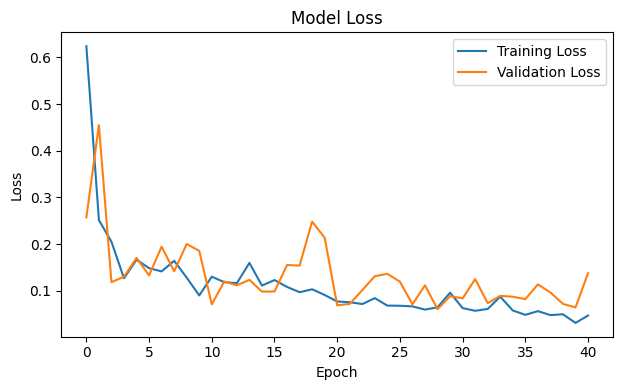

In [16]:
# Plot training & validation loss values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

# Plot training & validation accuracy values (if available)
if 'accuracy' in history.history:
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

In [30]:
# Evaluate the model on the validation data
evaluation = model_2.evaluate(val_generator)

# Print the evaluation results
print("Validation Loss:", evaluation[0])
print("Validation MAE (in months):", evaluation[1])


79/79 ━━━━━━━━━━━━━━━━━━━━ 122s 2s/step - loss: 0.0782 - mae_in_months: 8.9535
Validation Loss: 0.08088663220405579
Validation MAE (in months): 9.03808307647705


W0000 00:00:1716734522.392123     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Predicted bone age: 7.85 years


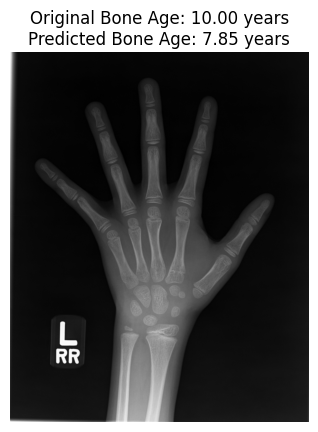

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.xception import preprocess_input

def load_and_preprocess_image(img_path, img_size=299):
    # Load the image
    img = image.load_img(img_path, target_size=(img_size, img_size))
    # Convert the image to array
    img_array = image.img_to_array(img)
    # Expand dimensions to match the input shape
    img_array = np.expand_dims(img_array, axis=0)ca
    # Preprocess the image
    img_array = preprocess_input(img_array)
    return img_array

def show_image_with_prediction(img_path, original_bone_age_years, predicted_bone_age_years):
    img = image.load_img(img_path)
    plt.imshow(img)
    plt.title(f'Original Bone Age: {original_bone_age_years:.2f} years\nPredicted Bone Age: {predicted_bone_age_years:.2f} years')
    plt.axis('off')
    plt.show()

# Example image path
img_path = '/kaggle/input/rsna-bone-age/boneage-training-dataset/boneage-training-dataset/10000.png'  # Update with your image path
img_array = load_and_preprocess_image(img_path)

# Predict the bone age z-score
predicted_bone_age_z = model_2.predict(img_array) 
# Convert z-score prediction to actual bone age in months
predicted_bone_age_months = predicted_bone_age_z * std_bone_age + mean_bone_age
# Convert bone age from months to years
predicted_bone_age_years = predicted_bone_age_months / 12.0

# Example original bone age in months (update with your actual value)
original_bone_age_months = 96  # Replace with the actual original bone age in months
original_bone_age_years = original_bone_age_months / 12.0

print(f'Predicted bone age: {predicted_bone_age_years[0][0]:.2f} years')
show_image_with_prediction(img_path, original_bone_age_years, predicted_bone_age_years[0][0])
